<a href="https://colab.research.google.com/github/ArnabiDutta/Neural-Style-Transfer-Implementation/blob/main/neural_style.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [26]:

%matplotlib inline

In [27]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
from torchvision.models import vgg19, VGG19_Weights
from google.colab import files

import copy

In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [29]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no GPU

print("Upload your STYLE image:")
uploaded_style = files.upload()
style_path = next(iter(uploaded_style))
style_pil = Image.open(style_path).convert("RGB")
style_pil = style_pil.resize((imsize, imsize))

print("Upload your CONTENT image:")
uploaded_content = files.upload()
content_path = next(iter(uploaded_content))
content_pil = Image.open(content_path).convert("RGB")
content_pil = content_pil.resize((imsize, imsize))

loader = transforms.Compose([
    transforms.ToTensor()
])

def image_loader(pil_img):
    image = loader(pil_img).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader(style_pil)
content_img = image_loader(content_pil)


Upload your STYLE image:


Saving starry night.jpeg to starry night (1).jpeg
Upload your CONTENT image:


Saving Screenshot 2025-04-06 034539.png to Screenshot 2025-04-06 034539 (1).png


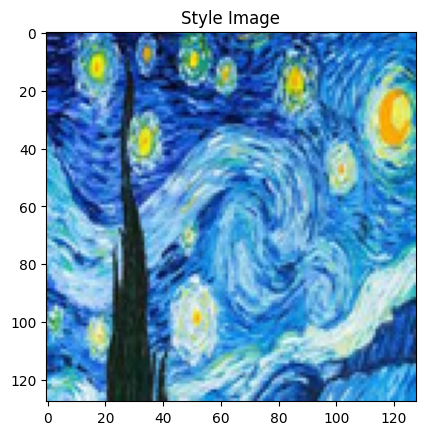

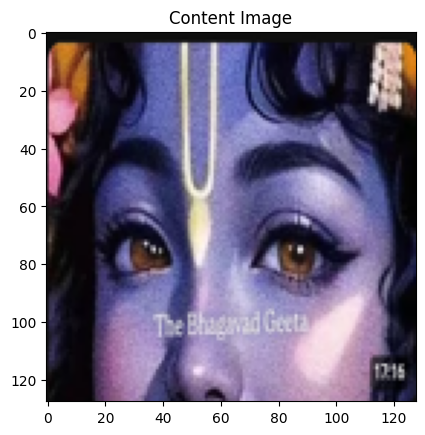

In [30]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

In [31]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        self.loss = 0

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [32]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [33]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        self.loss = 0

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [34]:
cnn = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()

In [35]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [36]:
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std)

    content_losses = []
    style_losses = []

    model = nn.Sequential(normalization)

    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)

            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

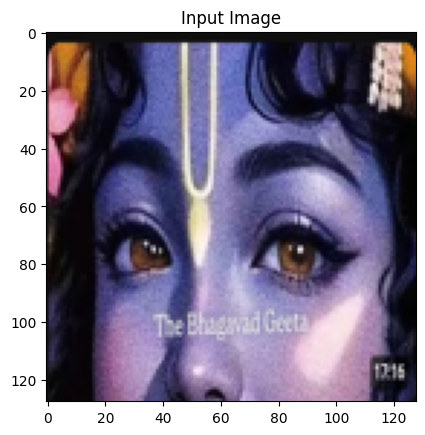

In [37]:
input_img = content_img.clone()

plt.figure()
imshow(input_img, title='Input Image')

In [38]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [39]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=1000000, content_weight=1):
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)


    input_img.requires_grad_(True)

    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 160.836258 Content Loss: 40.093742

run [100]:
Style Loss : 36.789177 Content Loss: 40.385441

run [150]:
Style Loss : 18.366621 Content Loss: 38.618618

run [200]:
Style Loss : 12.682805 Content Loss: 36.579502

run [250]:
Style Loss : 10.306048 Content Loss: 34.987675

run [300]:
Style Loss : 9.032347 Content Loss: 33.821213



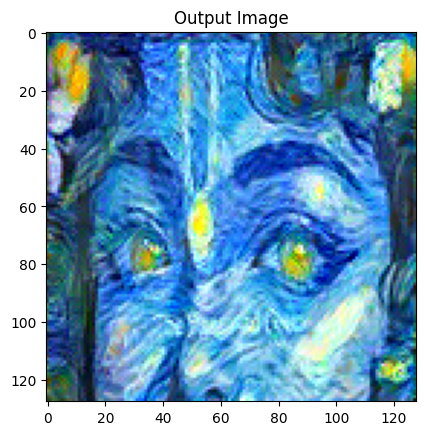

In [40]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

plt.ioff()
plt.show()